# Import Libraries and Define Functions

In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
from bs4 import BeautifulSoup

In [3]:
import json
import folium

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.cm as cm
import matplotlib.colors as colors

In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
def getNearbyVenues(names, latitudes, longitudes, limit=100, radius=500):
    
    venues_list=[]
    # Insert your Foursquare Client ID and Client Secret below
    CLIENT_ID = 'temp' # your Foursquare ID
    CLIENT_SECRET = 'temp' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP', 
                  'LAT', 
                  'LNG', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Get Zipcode, Population, and Lat./Long. Data

In [7]:
url = 'https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data'

In [8]:
lat_long = pd.read_csv(url)

In [9]:
url2 = 'https://www.zipdatamaps.com/zipcodes-seattle-wa'

In [10]:
data = requests.get(url2).text
soup = BeautifulSoup(data, 'html5lib')
table=soup.find('table')

In [11]:
census=[]
for row in table.find_all('tr'):
    if (row.table is None):
        pass
    else:
        zipcode = float(row.find_all('td')[4].text)
        pop = float(row.find_all('td')[6].text)
        census.append([zipcode, pop])
census = np.array(census)

In [12]:
del_list = []
for i, val in enumerate(census):
    if (val[1] < 5000):
        del_list.append(i)

In [13]:
type_dict = {'ZIP': int, 'Population': float}

In [14]:
zip_pop = pd.DataFrame(np.delete(census, del_list, axis=0), columns=['ZIP', 'Population']).astype(type_dict)

In [15]:
df = pd.merge(lat_long, zip_pop, on='ZIP', how='inner')

In [85]:
df.head()

,ZIP,LAT,LNG,Population
0,98034,47.715769,-122.213748,40407.0
1,98101,47.610902,-122.336422,10238.0
2,98102,47.637140,-122.321891,20756.0
3,98103,47.678255,-122.338152,45911.0
4,98104,47.601884,-122.329459,13095.0


In [84]:
df.head().to_csv('Zip_pop_loc.csv')

# Group and K-Means

In [16]:
seattle_venues = getNearbyVenues(names=df['ZIP'],
                                   latitudes=df['LAT'],
                                   longitudes=df['LNG'],
                                   radius=3200,
                                   limit=1000
                                  )

98034
98101
98102
98103
98104
98105
98106
98107
98108
98109
98112
98115
98116
98117
98118
98119
98121
98122
98125
98126
98133
98136
98144
98146
98155
98177
98178
98199


In [17]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['ZIP'] = seattle_venues['ZIP'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_grouped = seattle_onehot.groupby('ZIP').mean().reset_index()

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZIP']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZIP'] = seattle_grouped['ZIP']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,98034,Coffee Shop,Sushi Restaurant,Sandwich Place,Pizza Place,Gym / Fitness Center,Bar,Pet Store,Park,Clothing Store,Chinese Restaurant
1,98101,Hotel,Coffee Shop,Bakery,Sandwich Place,Cocktail Bar,Sushi Restaurant,Breakfast Spot,Wine Bar,Bar,Middle Eastern Restaurant
2,98102,Coffee Shop,Park,American Restaurant,Bakery,Sandwich Place,Italian Restaurant,Bar,Cocktail Bar,Taco Place,Scenic Lookout
3,98103,Coffee Shop,Bar,Ice Cream Shop,Park,Burger Joint,Pizza Place,Zoo Exhibit,Café,Japanese Restaurant,Playground
4,98104,Hotel,Vietnamese Restaurant,Cocktail Bar,Coffee Shop,French Restaurant,Sandwich Place,Ice Cream Shop,Breakfast Spot,Bookstore,Brewery


In [19]:
# set number of clusters
kclusters = 5

seattle_grouped_clustering = seattle_grouped.drop('ZIP', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 1, 1, 0, 1, 2, 2, 2, 1])

In [20]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [88]:
neighborhoods_venues_sorted.head().to_csv('Zip_CommonVenues.csv')

In [22]:
seattle_merged = df

# merge seattle_grouped with seattle_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('ZIP'), on='ZIP')

seattle_merged.head() # check the last columns!

,ZIP,LAT,LNG,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,98034,47.715769,-122.213748,40407.0,3,Coffee Shop,Sushi Restaurant,Sandwich Place,Pizza Place,Gym / Fitness Center,Bar,Pet Store,Park,Clothing Store,Chinese Restaurant
1,98101,47.610902,-122.336422,10238.0,0,Hotel,Coffee Shop,Bakery,Sandwich Place,Cocktail Bar,Sushi Restaurant,Breakfast Spot,Wine Bar,Bar,Middle Eastern Restaurant
2,98102,47.637140,-122.321891,20756.0,1,Coffee Shop,Park,American Restaurant,Bakery,Sandwich Place,Italian Restaurant,Bar,Cocktail Bar,Taco Place,Scenic Lookout
3,98103,47.678255,-122.338152,45911.0,1,Coffee Shop,Bar,Ice Cream Shop,Park,Burger Joint,Pizza Place,Zoo Exhibit,Café,Japanese Restaurant,Playground
4,98104,47.601884,-122.329459,13095.0,0,Hotel,Vietnamese Restaurant,Cocktail Bar,Coffee Shop,French Restaurant,Sandwich Place,Ice Cream Shop,Breakfast Spot,Bookstore,Brewery


In [23]:
latitude=47.6062
longitude=-122.3321

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['LAT'], seattle_merged['LNG'], seattle_merged['ZIP'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Calculate coffeeshops per 10,000 people

In [25]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['ZIP'] = seattle_venues['ZIP'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

In [26]:
seattle_new = seattle_onehot.groupby('ZIP').sum().reset_index()
ZIPS = seattle_new.loc[:,'ZIP']
cof1 = seattle_new.loc[:,'Coffee Shop']
cof2 = seattle_new.loc[:,'Café']
added = cof1 + cof2
coffees_by_zip = pd.concat([ZIPS, added], axis=1)
coffees_by_zip.rename(columns = {'ZIP': 'ZIP', 0: '#coffee_shops'}, inplace=True)

In [27]:
df_new = pd.merge(df, coffees_by_zip, on='ZIP', how='inner')
z = [10000*row['#coffee_shops']/row.Population for index, row in df_new.iterrows()]
df_new['coffee per capita'] = z

In [31]:
seattle_merged[['ZIP','Cluster Labels']]

,ZIP,Cluster Labels
0,98034,3
1,98101,0
2,98102,1
3,98103,1
4,98104,0
5,98105,1
6,98106,2
7,98107,2
8,98108,2
9,98109,1


In [35]:
df_new2 = pd.merge(df_new, seattle_merged[['ZIP','Cluster Labels']], on='ZIP', how='inner')

In [37]:
import matplotlib.pyplot as plt

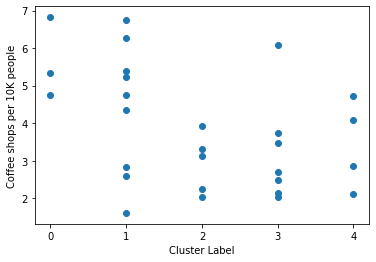

In [46]:
plt.scatter(df_new2['Cluster Labels'], df_new2['coffee per capita'])
labels=[0,1,2,3,4]
plt.xticks(labels)
plt.xlabel('Cluster Label')
plt.ylabel('Coffee shops per 10K people')
plt.show()

In [70]:
mins = df_new2.groupby('Cluster Labels').min()['coffee per capita']

In [76]:
winners = df_new2[df_new2['coffee per capita'].isin(mins)]

In [77]:
winners

,ZIP,LAT,LNG,Population,#coffee_shops,coffee per capita,Cluster Labels
5,98105,47.659861,-122.284977,43924.0,7,1.593662,1
14,98118,47.540246,-122.268545,42731.0,9,2.106199,4
16,98121,47.615192,-122.350581,12628.0,6,4.751346,0
20,98133,47.740485,-122.342826,44555.0,9,2.019975,3
27,98199,47.651371,-122.407349,19686.0,4,2.031901,2


In [89]:
winners.to_csv('best_zips.csv')

In [80]:
winners_format = winners.reset_index()

In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(winners_format['LAT'], winners_format['LNG'], winners_format['ZIP'], winners_format['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters